# Modeling and fitting


## Prerequisites

- Knowledge of spectral analysis to produce 1D On-Off datasets, [see the following tutorial](spectrum_analysis.ipynb)
- Reading of pre-computed datasets [see the MWL tutorial](analysis_mwl.ipynb)
- General knowledge on statistics and optimization methods

## Proposed approach

This is a hands-on tutorial to `~gammapy.modeling`, showing how the model, dataset and fit classes work together. As an example we are going to work with HESS data of the Crab Nebula and show in particular how to :
- perform a spectral analysis
- use different fitting backends
- acces covariance matrix informations and parameter errors
- compute likelihood profile
- compute confidence contours

See also: [Models gallery tutorial](models.ipynb) and `docs/modeling/index.rst`.


## The setup

In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit, Datasets
from gammapy.modeling.models import LogParabolaSpectralModel, SkyModel
from gammapy.spectrum import SpectrumDatasetOnOff


First we define the source model, here we need only a spectral model for which we choose a log-parabola

In [2]:
crab_spectrum = LogParabolaSpectralModel(amplitude=1e-11/u.cm**2/u.s/u.TeV,
                                     reference=1*u.TeV,
                                     alpha=2.3,
                                      beta=0.2)

crab_model = SkyModel(spectral_model=crab_spectrum, name="crab")


The data and background are read from pre-computed ON/OFF datasets of HESS observations, for simplicity we stack them together.
Then we set the model and fit range to the resulting dataset.

In [3]:
datasets = []
for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce(name="HESS")

# Set model and fit range
dataset_hess.models = crab_model
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset_hess.mask_fit = dataset_hess.counts.energy_mask(e_min, e_max)


## Fitting options



First let's create a `Fit` instance:

In [4]:
fit = Fit([dataset_hess])

By default the fit is performed using MINUIT, you can select alternative optimizers and set their option using the `optimize_opts` argument of the `Fit.run()` method.

Note that, for now, covaraince matrix and errors are computed only for the fitting with MINUIT. However depending on the problem other optimizers can better perform, so somethimes it can be usefull to run a pre-fit with alternative optimization methods.

For the "scipy" backend the available options are desribed in detail here:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [5]:
%%time
scipy_opts={"method": "L-BFGS-B", "options":{"ftol": 1e-4, 'gtol': 1e-05}}
result_scipy = fit.run(backend="scipy",  optimize_opts=scipy_opts)
print(result_scipy)


No covariance estimate - not supported by this backend.


OptimizeResult

	backend    : scipy
	method     : L-BFGS-B
	success    : True
	message    : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
	nfev       : 40
	total stat : 30.35

CPU times: user 339 ms, sys: 24.1 ms, total: 363 ms
Wall time: 797 ms


For the "sherpa" backend you can from the options method = {"simplex",  "levmar", "moncar", "gridsearch"}.  
Those methods are described and compared in detail on http://cxc.cfa.harvard.edu/sherpa/methods/index.html.  
The available options of the optimization methods are described on the following page https://cxc.cfa.harvard.edu/sherpa/methods/opt_methods.html

In [6]:
%%time
sherpa_opts={"method": "simplex", "ftol": 1e-3, "maxfev":int(1e4)}
results_simplex = fit.run(backend="sherpa", optimize_opts=sherpa_opts)
print(results_simplex)



No covariance estimate - not supported by this backend.


OptimizeResult

	backend    : sherpa
	method     : simplex
	success    : True
	message    : Optimization terminated successfully
	nfev       : 149
	total stat : 30.35

CPU times: user 281 ms, sys: 5.87 ms, total: 287 ms
Wall time: 318 ms


For the "minuit" backend see https://iminuit.readthedocs.io/en/latest/reference.html for a detailed description of the available options. If there is an entry ‘migrad_opts’, those options will be passed to [iminuit.Minuit.migrad](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.migrad). Additionnaly you can set the fit tolerance using the [tol](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.tol
) option. The minimization will stop when the estimated distance to the minimum is less than 0.001*tol (by default tol=0.1). The [strategy](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.strategy) option change the speed and accuracy of the optimizer: 0 fast, 1 default, 2 slow but accurate. If you want more reliable error estimates, you should run the final fit with strategy 2.


In [7]:
%%time
minuit_opts = {"tol": 1., "strategy": 2}
result_minuit = fit.run(backend="minuit" ,optimize_opts=minuit_opts)
print(result_minuit)
result_minuit.parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 41
	total stat : 30.35

CPU times: user 114 ms, sys: 5.27 ms, total: 119 ms
Wall time: 149 ms


name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
amplitude,3.814e-11,3.545e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
alpha,2.196e+00,2.626e-01,,nan,nan,False
beta,2.265e-01,1.397e-01,,nan,nan,False


## Covariance and parameter errors

The covariance matrix is attached to the results parameters object:

In [27]:
result_minuit.parameters.covariance

array([[ 1.25692105e-23,  0.00000000e+00,  4.52493453e-13,
        -1.15640749e-13],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.52493453e-13,  0.00000000e+00,  6.89801982e-02,
        -3.31300769e-02],
       [-1.15640749e-13,  0.00000000e+00, -3.31300769e-02,
         1.95110514e-02]])

You can get the error on a specific parameter by index or name: 

In [28]:
result_minuit.parameters.error("alpha")

0.26264081601982847

Coavariance information and errors are available in the results object, but they are not automatically synchronised with the model objects, you can do it as follow:

In [16]:
# set sub-covariance on the input spectral model
covar = result_minuit.parameters.get_subcovariance(crab_spectrum.parameters)
crab_spectrum.parameters.covariance = covar

[[ 1.25692105e-23  0.00000000e+00  4.52493453e-13 -1.15640749e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.52493453e-13  0.00000000e+00  6.89801982e-02 -3.31300769e-02]
 [-1.15640749e-13  0.00000000e+00 -3.31300769e-02  1.95110514e-02]]


As an exampke this step is needed to produce a butterfly plot showing the enveloppe of the model taking into account parameter uncertainties.

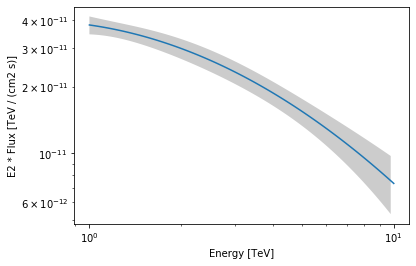

In [17]:
energy_range = [1, 10] * u.TeV
crab_spectrum.plot(energy_range=energy_range, energy_power=2)
ax = crab_spectrum.plot_error(energy_range=energy_range, energy_power=2)

## Inspecting fit statistic profiles

To check the quality of the fit it is also useful to plot fit statistic profiles for specific parameters.
For this we use `~gammapy.modeling.Fit.stat_profile()`.

In [8]:
profile = fit.stat_profile(parameter="alpha")

For a good fit and error estimate the profile should be parabolic, if we plot it:

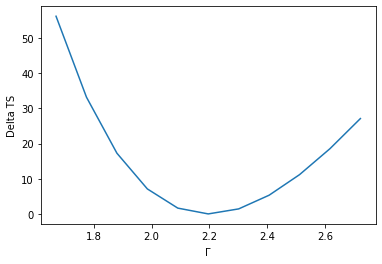

In [29]:
total_stat = result_minuit.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel(r"$\Gamma$")
plt.ylabel("Delta TS");

## Confidence contours


In most studies, one wishes to estimate parameters distribution using observed sample data.
A confidence interval gives an estimated range of values which is likely to include an unknown parameter.
The selection of a confidence level for an interval determines the probability that the confidence interval produced will contain the true parameter value.
A confidence contour is a 2D generalization of a confidence interval, often represented as an ellipsoid around the best-fit value.

After the fit, MINUIT offers the possibility to compute the confidence confours.
gammapy provides an interface to this functionnality throught the `Fit` object using the `minos_contour` method.
Here we defined a function to automatize the contour production for the differents parameterer and confidence levels (expressed in term of sigma):


In [10]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        contour = fit.minos_contour(result.parameters['alpha'], 
                                     result.parameters['beta'], 
                                     numpoints=npoints,
                                     sigma=sigma)
        contours["contour_alpha_beta"] = {
            "alpha": contour["x"].tolist(),
            "beta": (contour["y"]*np.log(10)).tolist(),
        }    

        contour = fit.minos_contour(result.parameters['amplitude'], 
                                     result.parameters['beta'], 
                                     numpoints=npoints,
                                     sigma=sigma)
        contours["contour_amplitude_beta"] = {
            "amplitude": contour["x"].tolist(),
            "beta": (contour["y"]*np.log(10)).tolist(),
        } 

        contour = fit.minos_contour(result.parameters['amplitude'], 
                                     result.parameters['alpha'], 
                                     numpoints=npoints,
                                     sigma=sigma)
        contours["contour_amplitude_alpha"] = {
            "amplitude": contour["x"].tolist(),
            "alpha": contour["y"].tolist(),
        }     
        cts_sigma.append(contours)
    return cts_sigma

Now we can compute few contours.

In [11]:
%%time
sigma = [1, 2]
cts_sigma = make_contours(fit, result_minuit, 10, sigma)

CPU times: user 9.81 s, sys: 95.7 ms, total: 9.9 s
Wall time: 11.9 s


The contours lines to be plotted are obtained by interpolating the contours points.
However there is some noise in the contour points from MINUIT, which throws off most interpolation schemes.
In order to avoid this we apply a median filter to remove the outliers before the spline interpolation.
This is done by the two following functions :
 

In [12]:
def plot_contour_line(ax, x, y, thr, **kwargs):
    """Plot smooth curve from contour points"""
    from scipy.interpolate import CubicSpline

    # close countour
    xf = np.append(x , x[0])
    yf = np.append(y , y[0])
    
    # curve parametrization must be strictly increasing 
    # so we use the cumulative distance of each point from the first one
    dist = np.sqrt(np.diff(xf)**2.+np.diff(yf)**2.)
    dist = [0]+list(dist)
    t = np.cumsum(dist)
    ts = np.linspace(0, t[-1], 50)
    
    # 1D cubic spline interpolation
    cs = CubicSpline(t, np.c_[xf, yf], bc_type='periodic')
    out = cs(ts)
    
    # plot
    ax.plot(out[:,0], out[:,1], "-",  **kwargs)
    ax.plot(xf, yf, '+', color=kwargs["color"])

    

Then we prepare some aliases and annotations in order to make the plotting nicer.

In [13]:
pars = {
    "phi": {
        "label": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
        "lim": [2.6, 5.8],
        "ticks": [3, 4, 5],
    },
    "gamma": {
        "label": r"$\Gamma$",
        "lim": [1.9, 3.],
        "ticks": [2., 2.3, 2.6, 2.9],
    },
    "beta": {
        "label": r"$\beta$",
        "lim": [-0.1, 1.0],
        "ticks": [0.0, 0.3, 0.6, 0.9],
    },
}

panels = [
    {
        "x": "phi",
        "y": "gamma",
        "cx": (lambda ct:np.array(1e11) * ct["contour_amplitude_alpha"]["amplitude"]),
        "cy": (lambda ct: ct["contour_amplitude_alpha"]["alpha"]),
    },
    {
        "x": "phi",
        "y": "beta",
        "cx": (lambda ct: np.array(1e11) * ct["contour_amplitude_beta"]["amplitude"]),
        "cy": (lambda ct: ct["contour_amplitude_beta"]["beta"]),
    },
    {
        "x": "gamma",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

    

Finally we produce the confidence contours figures.

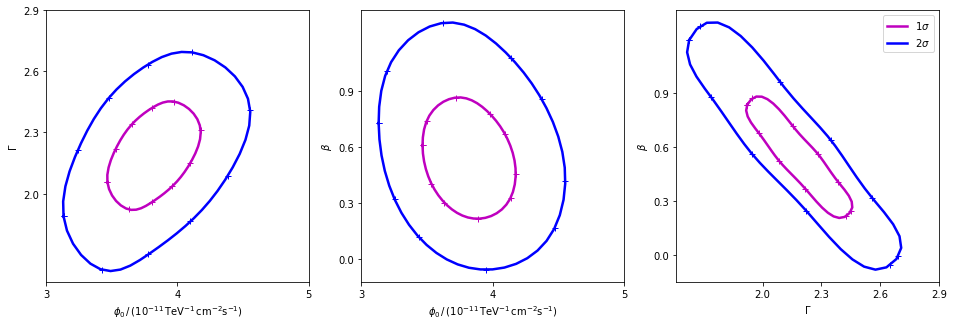

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors=['m','b','c']
for p, ax in zip(panels, axes):
    x = pars[p["x"]]
    y = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(ax, p["cx"](cts_sigma[ks]), p["cy"](cts_sigma[ks]), thr=2*sigma[ks], lw=2.5, color=colors[ks], label=f"{sigma[ks]}"+r"$\sigma$")
    ax.set_xlabel(x["label"])
    ax.set_ylabel(y["label"])
#    ax.set_xlim(x["lim"])
#    ax.set_ylim(y["lim"])
    ax.set_xticks(x["ticks"])
    ax.set_yticks(y["ticks"])
plt.legend();